In [1]:
%load_ext autoreload
import os, sys, glob
import json
import re
import numpy as np
import pandas as pd
import ast

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavioral/code/utils/')
sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/utils/gentle')

import gentle
from narratives_utils import *
from text_utils import get_pos_tags, get_lemma

# Set directories

In [40]:
EXPERIMENT_NAME = 'next-word-prediction'
EXPERIMENT_VERSION = 'pilot-version-03'

base_dir = '/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavioral/'
gentle_dir = os.path.join(base_dir, 'stimuli', 'gentle')
results_dir = os.path.join(base_dir, 'experiments',  EXPERIMENT_NAME, 'results', EXPERIMENT_VERSION)
preproc_dir = os.path.join(base_dir, 'stimuli', 'preprocessed')

# for huggingface
cache_dir = '/dartfs/rc/lab/F/FinnLab/tommy/models/huggingface/transformers'

In [376]:
# go through each task and get participant data
EXPERIMENT_NAME = 'next-word-prediction'
EXPERIMENT_VERSION = 'pilot-version-04'
TASK = 'black'

base_dir = '/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavioral/'
results_dir = os.path.join(base_dir, 'experiments',  EXPERIMENT_NAME, 'results', EXPERIMENT_VERSION)
source_dir = os.path.join(base_dir, 'stimuli',  'presentation_orders', EXPERIMENT_VERSION, TASK)

sources_fns = sorted(glob.glob(os.path.join(source_dir, '*')))

In [452]:
checker = {
    'complete': [],
    'incomplete': [],
    'error': [],
    'missing': [],
}

for source_fn in sources_fns:
    
    # get the basename and split to get subject name
    sub = os.path.basename(source_fn).split('_')[0]
    
    # then load the parameters
    parameter_data = pd.read_json(source_fn, orient='records')
    
    for mod in modalities:
        sub_results_dir = os.path.join(results_dir, mod, sub)
        
        # check if the file exists
        if not os.path.exists(sub_results_dir):
            checker['missing'].append((mod, sub))
            
        # load results from the completed experiment
        try:
            current_id, results = load_participant_results(sub_results_dir, sub)
        except:
            if os.path.exists(sub_results_dir):
                checker['error'].append((mod, sub))
            continue
            
        # check that all indices of trials match
        all_values_complete = np.all(results['transcript_index'].values == parameter_data[parameter_data['NWP_Candidate']].index.values)

        # make sure all responses are there
        all_responses_complete = np.all(~pd.isnull(results['response']))
        
        if all_values_complete and all_responses_complete:
            # add to list of people completed
            checker['complete'].append((mod, sub, current_id))
        else:
            checker['incomplete'].append((mod, sub, current_id))
            
        del current_id
            
#         sys.exit(0)

Find people who completed the whole study or didn't

In [453]:
complete = pd.DataFrame(checker['complete'], columns=['modality', 'sub', 'prolific_id'])
incomplete = pd.DataFrame(checker['incomplete'], columns=['modality', 'sub', 'prolific_id'])
error = pd.DataFrame(checker['error'], columns=['modality', 'sub'])


In [458]:
complete[complete['prolific_id'] == '63d176dbaef5e7827cd86954']

,modality,sub,prolific_id


In [459]:
incomplete

,modality,sub,prolific_id


In [441]:
missing = pd.DataFrame(checker['missing'], columns=['modality', 'sub'])
missing

,modality,sub
0,audio,sub-00044
1,audio,sub-00101
2,audio-text,sub-00101


In [401]:
len(complete) + len(missing)

303

Then find duplicates

In [437]:
# find sets of duplicates between complete and incomplete
duplicate_prolific_ids = set(complete['prolific_id']).intersection(incomplete['prolific_id'])

complete_duplicate = complete[complete['prolific_id'].isin(duplicate_prolific_ids)]
incomplete_duplicate = incomplete[incomplete['prolific_id'].isin(duplicate_prolific_ids)]

In [438]:
incomplete_duplicate

,modality,sub,prolific_id


In [439]:
complete_duplicate

,modality,sub,prolific_id


Manually look at these files

Cleaned completed

In [387]:
complete_cleaned = complete[~complete['prolific_id'].isin(duplicates)]
incomplete_cleaned = incomplete[~incomplete['prolific_id'].isin(duplicates)]

In [388]:
incomplete_cleaned

,modality,sub,prolific_id
0,text,sub-00079,5d519a9df20feb00180b62bc
1,text,sub-00088,5bacb6b9f2d97e0001c52a63
2,audio,sub-00101,5de33ff0cc246f3633dc01d2


Write out IDs to approve

In [233]:
complete_cleaned['prolific_id'].to_csv('completed_cleaned.txt', index=False)

# Get data for stories

In [183]:
def load_participant_results(sub_dir, sub):
    # load and filter down to response trials
    df_results = pd.read_csv(os.path.join(sub_dir, f'{sub}_next-word-prediction.csv')).fillna(False)
    prolific_id = list(set(df_results['prolific_id']))
    
    df_results = df_results[df_results['critical_trial']]
    
    # convert string to dictionary
    df_results['response'] = df_results['response'].apply(ast.literal_eval)

    # filter down to the expeirment get the responses
    df_results = df_results[df_results['experiment_phase'] == 'experiment']
    df_results['response'] = [d.get('Q0') for d in df_results['response']]
    
    df_results['transcript_index'] = df_results['transcript_index'].astype(int) - 1
    
    return prolific_id[0], df_results

def add_word_response(dict, key, value):
    
    if key in dict:
        dict[key].append(value)
    else:
        dict[key] = [value]
        
    return dict

In [4]:
tasks = ['black', 'bronx']
task = tasks[0]
transcript = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript_preprocessed.csv'))

In [7]:
tasks_dict = {}

for task in tasks:
    transcript = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript_preprocessed.csv'))
    
    # go through each task and get participant data
    sub_dirs = sorted(glob.glob(os.path.join(results_dir, task, '*')))

    accuracy_stack = []
    transcript_responses = {}

    for sub_dir in sub_dirs:
        sub = os.path.basename(sub_dir)

        results = load_participant_results(sub_dir, sub)
        
        sys.exit(0)

        # calculate prediction accuracy
        accuracy = np.sum(results['current_word'] == results['response']) / len(results['current_word'])
        accuracy_stack.append(accuracy)

        for index, response in results[['transcript_index', 'response']].values:
            transcript_responses = add_word_response(transcript_responses, index, response)
            
    tasks_dict[task] = {
        'transcript': transcript['Word_Written'].values,
        'accuracy': np.stack(accuracy_stack),
        'responses': transcript_responses
    }


ValueError: need at least one array to stack

# Test transformer predictions

In [400]:
import torch
from torch.nn import functional as F
from scipy.special import rel_entr
from scipy import stats

def get_transformer_model(model_name, cache_dir=None):
    '''
    Use a model from the sentence-transformers library to get
    sentence embeddings. Models used are trained on a next-sentence
    prediction task and evaluate the likelihood of S2 following S1.
    '''
    # set the path of where to download models
    # this NEEDS to be run before loading from transformers
    if cache_dir:
        os.environ['TRANSFORMERS_CACHE'] = cache_dir
    from transformers import AutoTokenizer, AutoModelForCausalLM

    # load a tokenizer and a model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    return tokenizer, model

def get_model_prediction(inputs, model, tokenizer):
    
    tokens = tokenizer(inputs, return_tensors="pt")
    
    with torch.no_grad():
        logits = model(**tokens).logits[:, -1, :]
    
    probs = F.softmax(logits, dim=-1)
    pred_id = logits.argmax().item()
    pred_word = tokenizer.decode(pred_id)
    pred_prob = probs.max()
    
    return pred_word, pred_prob, probs

def get_segment_indices(n_words, window_size):
    
    temp_window = 0
    indices = [
        np.arange(i-window_size, i) if i > window_size else np.arange(0, i)
        for i in range(1, n_words)
    ]
    return indices

def process_transcript(transcript, model, tokenizer, window_size):
    
    prev_dist = None
    kl_divergence = None
    segments = get_segment_indices(n_words=len(transcript), window_size=window_size)
    df = pd.DataFrame([np.concatenate((np.array([transcript[0]]), np.repeat(np.nan, 3)))],
        columns=['predicted_word', 'probability', 'entropy', 'kl_divergence'])
    
    for i, seg in enumerate(segments):
        inputs = transcript[seg].tolist()
        inputs = ' '.join(inputs)
    
        word, prob, dist = get_model_prediction(inputs=inputs, model=model, tokenizer=tokenizer)
        entropy = stats.entropy(dist, axis=-1)[0]

        # set as previous distribution
        if not i or prev_dist is None:
            prev_dist = dist
        else:
            kl_divergence = rel_entr(dist, prev_dist).sum()

        df.loc[len(df)] = {
            'predicted_word': word,
            'probability': prob.item(),
            'entropy': entropy,
            'kl_divergence': kl_divergence.item() if kl_divergence is not None else None,
        }
        print (f'Processed segment {i+1}/{len(segments)}')
    return df

Get the tokenizer and model for GPT2

In [421]:
window_size = 25
words = transcript['Word_Written'].values
df = process_transcript(transcript=words, model=model, tokenizer=tokenizer, window_size=window_size)

out_fn = f'task-{task}_gpt2-predictions_context-{window_size}.csv'
df.to_csv(out_fn)

Processed segment 1/1375
Processed segment 2/1375
Processed segment 3/1375
Processed segment 4/1375
Processed segment 5/1375
Processed segment 6/1375
Processed segment 7/1375
Processed segment 8/1375
Processed segment 9/1375
Processed segment 10/1375
Processed segment 11/1375
Processed segment 12/1375
Processed segment 13/1375
Processed segment 14/1375
Processed segment 15/1375
Processed segment 16/1375
Processed segment 17/1375
Processed segment 18/1375
Processed segment 19/1375
Processed segment 20/1375
Processed segment 21/1375
Processed segment 22/1375
Processed segment 23/1375
Processed segment 24/1375
Processed segment 25/1375
Processed segment 26/1375
Processed segment 27/1375
Processed segment 28/1375
Processed segment 29/1375
Processed segment 30/1375
Processed segment 31/1375
Processed segment 32/1375
Processed segment 33/1375
Processed segment 34/1375
Processed segment 35/1375
Processed segment 36/1375
Processed segment 37/1375
Processed segment 38/1375
Processed segment 39/

Processed segment 309/1375
Processed segment 310/1375
Processed segment 311/1375
Processed segment 312/1375
Processed segment 313/1375
Processed segment 314/1375
Processed segment 315/1375
Processed segment 316/1375
Processed segment 317/1375
Processed segment 318/1375
Processed segment 319/1375
Processed segment 320/1375
Processed segment 321/1375
Processed segment 322/1375
Processed segment 323/1375
Processed segment 324/1375
Processed segment 325/1375
Processed segment 326/1375
Processed segment 327/1375
Processed segment 328/1375
Processed segment 329/1375
Processed segment 330/1375
Processed segment 331/1375
Processed segment 332/1375
Processed segment 333/1375
Processed segment 334/1375
Processed segment 335/1375
Processed segment 336/1375
Processed segment 337/1375
Processed segment 338/1375
Processed segment 339/1375
Processed segment 340/1375
Processed segment 341/1375
Processed segment 342/1375
Processed segment 343/1375
Processed segment 344/1375
Processed segment 345/1375
P

Processed segment 613/1375
Processed segment 614/1375
Processed segment 615/1375
Processed segment 616/1375
Processed segment 617/1375
Processed segment 618/1375
Processed segment 619/1375
Processed segment 620/1375
Processed segment 621/1375
Processed segment 622/1375
Processed segment 623/1375
Processed segment 624/1375
Processed segment 625/1375
Processed segment 626/1375
Processed segment 627/1375
Processed segment 628/1375
Processed segment 629/1375
Processed segment 630/1375
Processed segment 631/1375
Processed segment 632/1375
Processed segment 633/1375
Processed segment 634/1375
Processed segment 635/1375
Processed segment 636/1375
Processed segment 637/1375
Processed segment 638/1375
Processed segment 639/1375
Processed segment 640/1375
Processed segment 641/1375
Processed segment 642/1375
Processed segment 643/1375
Processed segment 644/1375
Processed segment 645/1375
Processed segment 646/1375
Processed segment 647/1375
Processed segment 648/1375
Processed segment 649/1375
P

Processed segment 917/1375
Processed segment 918/1375
Processed segment 919/1375
Processed segment 920/1375
Processed segment 921/1375
Processed segment 922/1375
Processed segment 923/1375
Processed segment 924/1375
Processed segment 925/1375
Processed segment 926/1375
Processed segment 927/1375
Processed segment 928/1375
Processed segment 929/1375
Processed segment 930/1375
Processed segment 931/1375
Processed segment 932/1375
Processed segment 933/1375
Processed segment 934/1375
Processed segment 935/1375
Processed segment 936/1375
Processed segment 937/1375
Processed segment 938/1375
Processed segment 939/1375
Processed segment 940/1375
Processed segment 941/1375
Processed segment 942/1375
Processed segment 943/1375
Processed segment 944/1375
Processed segment 945/1375
Processed segment 946/1375
Processed segment 947/1375
Processed segment 948/1375
Processed segment 949/1375
Processed segment 950/1375
Processed segment 951/1375
Processed segment 952/1375
Processed segment 953/1375
P

Processed segment 1213/1375
Processed segment 1214/1375
Processed segment 1215/1375
Processed segment 1216/1375
Processed segment 1217/1375
Processed segment 1218/1375
Processed segment 1219/1375
Processed segment 1220/1375
Processed segment 1221/1375
Processed segment 1222/1375
Processed segment 1223/1375
Processed segment 1224/1375
Processed segment 1225/1375
Processed segment 1226/1375
Processed segment 1227/1375
Processed segment 1228/1375
Processed segment 1229/1375
Processed segment 1230/1375
Processed segment 1231/1375
Processed segment 1232/1375
Processed segment 1233/1375
Processed segment 1234/1375
Processed segment 1235/1375
Processed segment 1236/1375
Processed segment 1237/1375
Processed segment 1238/1375
Processed segment 1239/1375
Processed segment 1240/1375
Processed segment 1241/1375
Processed segment 1242/1375
Processed segment 1243/1375
Processed segment 1244/1375
Processed segment 1245/1375
Processed segment 1246/1375
Processed segment 1247/1375
Processed segment 12

# Process participant data

In [474]:
from matplotlib import pyplot as plt
import seaborn as sns

In [473]:
df_accuracy = pd.DataFrame(columns=['task','accuracy'])

for task in tasks:
    
    accuracy = tasks_dict[task]['accuracy']
    df_temp = pd.DataFrame(
        np.stack((np.repeat(task, len(accuracy)), accuracy)).T, 
        columns=columns
    )
    
    df_accuracy = pd.concat([df_accuracy, df_temp])
    
df_accuracy['accuracy'] = df_accuracy['accuracy'].astype(float)

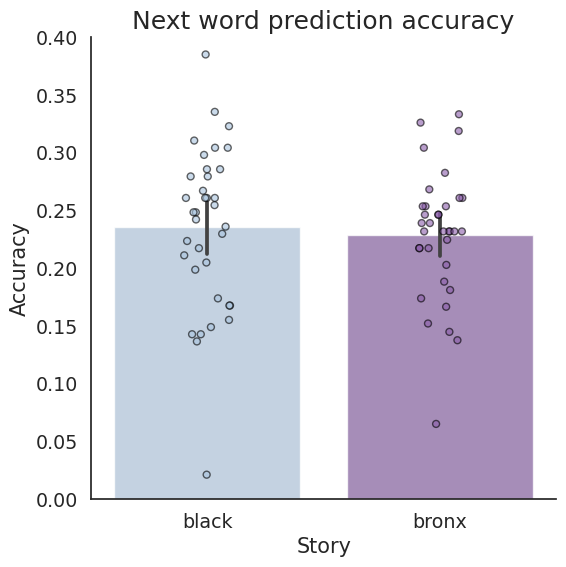

In [801]:
sns.set(style='white', rc={'figure.figsize':(6,6), "axes.titlesize":18}, font_scale=1.25)

ax = sns.barplot(data=df_accuracy, x='task', y='accuracy', palette='BuPu', alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_accuracy, x='task', y='accuracy', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=True, alpha=0.6, ax=ax)
plt.xlabel('Story')
plt.ylabel('Accuracy')
plt.title('Next word prediction accuracy')
plt.ylim(0, 0.4)

sns.despine()


# Plot example word distributions

In [501]:
import random

(0.248032, 0.014439, 0.612868)

In [603]:
cm

[(0.7480046136101499, 0.8267435601691656, 0.9015916955017301),
 (0.5490196078431373, 0.5855901576316801, 0.7751787773933103),
 (0.5326874279123414, 0.2502883506343714, 0.612641291810842)]

Text(0.5, 1.05, 'Behavioral predictions - Bronx')

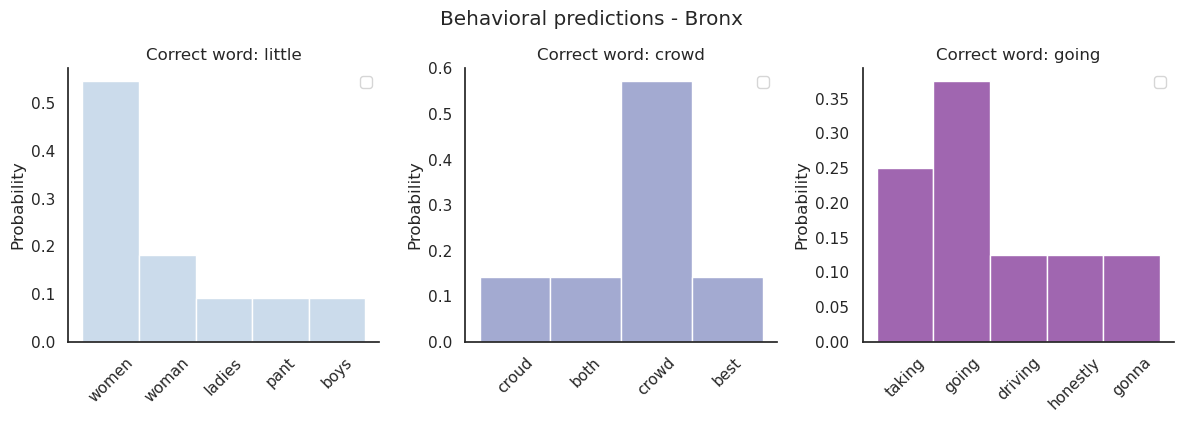

In [848]:
sns.set(style='white', rc={'figure.figsize':(12,4), "axes.titlesize":12})

n_indices = 3

fig, axes = plt.subplots(1, n_indices)
axes = axes.flatten()
counter = 0

# for task in tasks:
task = tasks[1]

cmap = sns.color_palette("BuPu",n_indices) #Splitting the palette in the same amount of numbers bins


task_transcript = tasks_dict[task]['transcript']
task_responses = tasks_dict[task]['responses']
response_indices = random.sample(list(task_responses.keys()), n_indices)

for ax, cm, idx in zip(axes, cmap, response_indices):
    sns.histplot(task_responses[idx], stat="probability", ax=ax, color=cm, alpha=0.8)
    ax.set_ylabel('Probability')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    sns.despine()
    ax.title.set_text(f'Correct word: {task_transcript[idx]}')
    counter += 1
    
plt.tight_layout()
plt.suptitle(f'Behavioral predictions - {task.capitalize()}', y=1.05)

# Compare responses to GPT

In [1035]:
from scipy.stats import pearsonr
task = tasks[0]

model_fn = f'task-{task}_gpt2-predictions_context-{window_size}.csv'
df_model = pd.read_csv(model_fn)

In [1040]:
task_transcript = tasks_dict[task]['transcript']
task_responses = tasks_dict[task]['responses']
response_idxs = list(task_responses.keys())

df_comparison = pd.DataFrame(
    columns=['ground_truth', 'prob_human', 'prob_model', 'pred_human', 'pred_model', 'entropy', 'kl_divergence']
)

for idx in response_idxs:

    unique, counts = np.unique(task_responses[idx], return_counts=True)
    probs = counts / sum(counts)
    
    ground_truth = task_transcript[idx]

    pred_human = unique[probs.argmax()]
    pred_model = df_model.loc[idx]['predicted_word']
    
    prob_human = probs.max()
    prob_model = df_model.loc[idx]['probability']
    
    df_comparison.loc[len(df_comparison)] = {
        'ground_truth': ground_truth,
        'prob_human': prob_human,
        'prob_model': prob_model,
        'pred_human': pred_human,
        'pred_model': pred_model,
        'entropy': df_model.loc[idx]['entropy'],
        'kl_divergence': df_model.loc[idx]['kl_divergence'],
    }

df_comparison['pred_model'] = df_comparison['pred_model'].str.strip()

In [1037]:
colors = df_comparison['prob_human'] - df_comparison['prob_model']
cmap = sns.color_palette("BuPu",9) #Splitting the palette in the same amount of numbers bins

In [1041]:
human_right = (df_comparison['pred_human'] == df_comparison['ground_truth']).values
model_right = (df_comparison['pred_model'] == df_comparison['ground_truth']).values

both_right = np.logical_and(human_right, model_right)
both_wrong = np.logical_and(~human_right, ~model_right)

df_comparison['response_comparisons'] = ''
df_comparison['response_comparisons'][both_wrong] = 'Both incorrect'
df_comparison['response_comparisons'][human_right] = 'Human correct'
df_comparison['response_comparisons'][model_right] = 'Model correct'
df_comparison['response_comparisons'][both_right] = 'Both correct'

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/narratives/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/narratives/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/narratives/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [ ]:
sns.set(style='white', rc={'figure.figsize':(8,6), "axes.titlesize":16}, font_scale=1.25)

# fig, axes = plt.subplots(2,3)
# axes = axes.flatten()



df_comparison = df_comparison.sort_values(by='response_comparisons')

ax = sns.scatterplot(
    data=df_comparison, x="prob_human", y="prob_model",
    s=35, edgecolor='gray', alpha=0.75, #color=cmap[2],
    palette='hls', hue="response_comparisons", 
)

ax.legend_.set_title(None)
ax.legend(fontsize=10, loc=4)


r, pval = pearsonr(df_comparison['prob_human'], df_comparison['prob_model'])

# # f'Pearson r = {r:.2f}'
sns.regplot(data=df_comparison, x="prob_human", y="prob_model",  scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)
plt.title(f'Word predictability - {task.capitalize()}')
plt.xlabel('Human prediction')
plt.ylabel('GPT prediction')

# # Hide the right and top spines
sns.despine()
# plt.legend(handlelength=0, handletextpad=0, loc=4,  prop={'size': 16})

# plt.tight_layout()



In [700]:
task_transcript

array(['So', 'I', 'was', ..., 'do', 'Thank', 'you'], dtype=object)

In [698]:
human_prediction

'know'

In [702]:
ground_truth

'was'

,Unnamed: 0,predicted_word,probability,entropy,kl_divergence
2,2,'m,0.098329,4.578187,3.378128
6,6,high,0.697481,1.547684,7.076402
9,9,was,0.147181,4.066482,4.340055
23,23,easy,0.075210,6.078683,4.947401
25,25,not,0.128821,4.625387,3.348750
...,...,...,...,...,...
1508,1508,can,0.217412,3.176548,4.263406
324,324,much,0.728475,1.655667,5.022173
100,100,of,0.648846,2.623734,3.157355
173,173,put,0.121370,5.184013,2.259360


# Show some probability distributions

In [347]:
df = df.append(last.iloc[-1], ignore_index=True)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
trial_index = 35
sns.histplot(transcript_responses[trial_index], stat="probability")
plt.title(f'Correct word: {all_words[trial_index]}')


In [ ]:
sns.histplot(transcript_responses[45])

In [ ]:
all_words[35]

In [ ]:
import seaborn as sns

In [ ]:
transcript_responses[26]

In [ ]:
sns.histplot(transcript_responses[26])

In [ ]:
for k, v in transcript_responses.items():
    print (len(v))

In [ ]:
results

In [ ]:
accuracy_stack

In [ ]:
critical_trials.response.iloc[0]

In [ ]:
df.apply(lambda x: ast.literal_eval(x))

In [155]:
dist.sum()

tensor(1.0000)

In [ ]:
[d.get('Q0') for d in df_results.response]

In [ ]:
task = 'black' # replace this string with those above

# set directories
base_dir = '/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavioral/'
# narratives_dir = '/dartfs/rc/lab/D/DBIC/DBIC/archive/narratives'

gentle_dir = os.path.join(base_dir, 'stimuli', 'gentle')
preproc_dir = os.path.join(base_dir, 'stimuli', 'preprocessed')

task_out_dir = os.path.join(preproc_dir, task)

if not os.path.exists(task_out_dir):
    os.makedirs(task_out_dir)